In [2]:
import pandas as pd

from actors import (Ship, Geopoint, speed_limitations, detect_point_category, IceCategory,
                    VesselCategory, Port, Geopoint, VesselMoveStatus, Icebreaker, Route)
from utils import find_and_serialize_neighbors, load_serialized_neighbors
from route_metrics import ice_metrics_on_route, get_closest_grid_points_on_route_step, route_steps_on_edge, ice_integral_coefficient_on_step

## Готовим данные

In [3]:
import pandas as pd

from actors import (Ship, Geopoint, speed_limitations, detect_point_category, IceCategory,
                    VesselCategory, Port, Geopoint, VesselMoveStatus, Icebreaker, Route)
from utils import find_and_serialize_neighbors, load_serialized_neighbors
from route_metrics import ice_metrics_on_route, get_closest_grid_points_on_route_step, route_steps_on_edge, ice_integral_coefficient_on_step
grid = pd.read_excel(r"data\velocity.xlsx")
routes = pd.read_excel(r"data\routes.xlsx")
ports = pd.read_excel(r"data\ports.xlsx")
vessels = pd.read_excel(r"data\vessels.xlsx")
iceboats = pd.read_excel(r"data\iceboat.xlsx")
schedule = pd.read_excel(r"data\schedule.xlsx")

In [47]:
grid = pd.read_excel(r"data\velocity.xlsx")
find_and_serialize_neighbors(grid=grid[["lat", "lon"]].values, static_folder="data")

In [65]:
grid.iloc[:, :3].sort_values(by=['lon', 'lat'])

,lon,lat,03-Mar-2020
538,20,64.3528,-10.0
269,20,64.3556,-10.0
0,20,64.3565,-10.0
539,20,64.5666,-10.0
270,20,64.5694,-10.0
...,...,...,...
120,200,89.1007,-10.0
119,200,89.3255,-10.0
118,200,89.5503,-10.0
117,200,89.7752,-10.0


## Примеры создания акторов

In [4]:
# Класс порта (узлы графа)
Port(name=ports["point_name"][0], geopoint=Geopoint(ports["lat"][0], ports["lon"][0]))

Port(name='Бухта Север и Диксон', geopoint=Geopoint(latitude=73.1, longitude=80.0))

In [5]:
# Класс ледокола
icebreaker = Icebreaker(name="Вайгач",
     category=VesselCategory.arc92,
     location_point=Port(
         name="Победа месторождение", geopoint=Geopoint(68.5, 73.7)
     ),
     route_request=None,
     status=VesselMoveStatus.waiting,
     max_speed=20,
     avg_speed=0.0,
     curr_speed=0.0)
icebreaker

Icebreaker(name='Вайгач', category=<VesselCategory.arc92: 10>, location_point=Port(name='Победа месторождение', geopoint=Geopoint(latitude=68.5, longitude=73.7)), route_request=None, status=<VesselMoveStatus.waiting: 0>, max_speed=20, avg_speed=0.0, curr_speed=0.0)

In [6]:
# Класс корабля
ship = Ship(name="ДЮК II",
     category=VesselCategory.arc5,
     location_point=Port(name="Новый порт", geopoint=Geopoint(68.5, 73.7)),
     route_request=None,
     status=VesselMoveStatus.waiting,
     max_speed=25,
     avg_speed=0.0,
     curr_speed=0.0)
ship

Ship(name='ДЮК II', category=<VesselCategory.arc5: 5>, location_point=Port(name='Новый порт', geopoint=Geopoint(latitude=68.5, longitude=73.7)), route_request=None, status=<VesselMoveStatus.waiting: 0>, max_speed=25, avg_speed=0.0, curr_speed=0.0)

In [135]:
from geopy.distance import great_circle

In [139]:
great_circle((65.2, 65.2), (65.3, 65.3)).km

12.054671625000664

In [7]:
# Ограничения на скорость в зависимости от судна и льда
speed_limitations[detect_point_category(17)](ship)

20.0

In [8]:
# Класс Route
route = Route(ports=[
    Port(name=ports["point_name"][0], geopoint=Geopoint(ports["lat"][0], ports["lon"][0])),
    Port(name=ports["point_name"][1], geopoint=Geopoint(ports["lat"][1], ports["lon"][1]))
])

route

Route(ports=[Port(name='Бухта Север и Диксон', geopoint=Geopoint(latitude=73.1, longitude=80.0)), Port(name='Дудинка', geopoint=Geopoint(latitude=69.4, longitude=86.15))], steps=[[(73.09, 80.0), (73.08, 80.01), (73.08, 80.02), (73.07, 80.03), (73.07, 80.04), (73.06, 80.05), (73.05, 80.06), (73.05, 80.07), (73.04, 80.08), (73.04, 80.09), (73.03, 80.1), (73.02, 80.11), (73.02, 80.12), (73.01, 80.13), (73.01, 80.14), (73.0, 80.15), (72.99, 80.16), (72.99, 80.17), (72.98, 80.18), (72.98, 80.19), (72.97, 80.2), (72.96, 80.21), (72.96, 80.22), (72.95, 80.23), (72.95, 80.24), (72.94, 80.25), (72.93, 80.26), (72.93, 80.27), (72.92, 80.28), (72.92, 80.29), (72.91, 80.3), (72.9, 80.31), (72.9, 80.32), (72.89, 80.33), (72.89, 80.34), (72.88, 80.35), (72.87, 80.36), (72.87, 80.37), (72.86, 80.38), (72.86, 80.39), (72.85, 80.4), (72.84, 80.41), (72.84, 80.42), (72.83, 80.43), (72.83, 80.44), (72.82, 80.45), (72.81, 80.46), (72.81, 80.47), (72.8, 80.48), (72.8, 80.49), (72.79, 80.5), (72.78, 80.51),

In [9]:
# Расчет состояния льда для ребра 0 в route
route.ice_state_on_edge(date=2, grid=grid.values, pair_idx=0)

C:\Users\Lenovo\code\hack_led\nothern_sea_router\route_metrics.py:43: RuntimeWarning: Mean of empty slice.
  res = np.where(ice_metric<=0, ice_metric[ice_metric>0].mean(), ice_metric)
D:\home\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(array([12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 12.1003065, 12.1003065, 12.1003065, 12.1003065,
        12.1003065, 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 12.1003065, 12.1003065, 10.       ,
        10.       , 10.       , 10.       , 10.       , 10.       ,
        10.       , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
        11.807345 , 11.807345 , 11.807345 , 11.8

### Детали по Route

In [68]:
# Вычисление всех квадратов на ребре
all_points_on_edge = route_steps_on_edge(67.58,	47.82,	70.30,	57.80)
all_points_on_edge[:10]

[(67.58, 47.82),
 (67.58, 47.83),
 (67.59, 47.84),
 (67.59, 47.85),
 (67.59, 47.86),
 (67.59, 47.87),
 (67.6, 47.88),
 (67.6, 47.89),
 (67.6, 47.9),
 (67.6, 47.91)]

In [70]:
serialized_neighbors = load_serialized_neighbors("data")
_, neighbors = serialized_neighbors.kneighbors([(67.22, 47.22)])
ice_integral_coefficient_on_step(neighbors, grid.values, 3)

In [72]:
get_closest_grid_points_on_route_step(serialized_neighbors, [(67.22, 47.22)])

[[12937, 12668, 12667, 12936]]

In [82]:
_, neighbors = serialized_neighbors.kneighbors([(67.22, 47.22)])

In [85]:
ice_integral_coefficient_on_step(neighbors, grid.values, 3)

array([[21.904749, 21.660614, 21.904749, 21.855923]])

In [79]:
ice_metrics_on_route(
    closest_quadrants=[[12938, 12937, 12668, 12667, 12936, 12935]],
    grid=grid.values,
    date_num_col=5
)

(array([21.855923]), {21.855923})

In [11]:
# Поиск ближайших соседей для расчета метрик
closest = get_closest_grid_points_on_route_step(load_serialized_neighbors("data"), all_points_on_edge)
closest[:10]

[[12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938],
 [12939, 13208, 12940, 12938]]

In [69]:
%timeit get_closest_grid_points_on_route_step(load_serialized_neighbors("data"), all_points_on_edge)

6.76 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
# Метрики на маршруте - все клетки и только уникальные
ice_metrics_on_route(
    closest_quadrants=closest,
    grid=grid.values,
    date_num_col=2
)

(array([20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.645016, 20.645016, 20.645016, 20.645016, 20.645016,
        20.645016, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.430178, 20.430178, 20.430178, 20.430178,
        20.430178, 20.430178, 20.43017

In [1]:
ice_integral_coefficient_on_step()

NameError: name 'ice_integral_coefficient_on_step' is not defined

<Axes: >

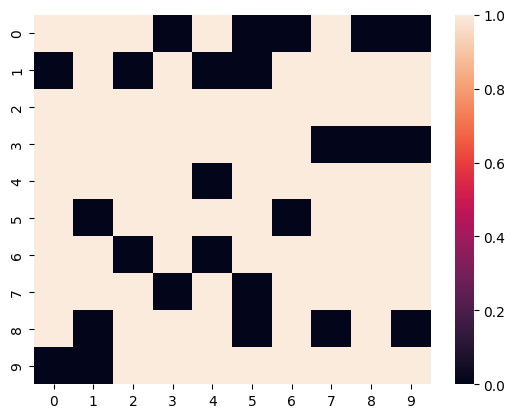

In [41]:
from seaborn import heatmap
from envs.waterworld import WaterWorld

map_shape = (10, 10)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (9, 9),
    'max_episode_steps': 25,
}
heatmap(water_map)

In [42]:
from ray.rllib.algorithms import PPOConfig

try:
    algo.stop()
except:
    pass

training_options = {
    'train_batch_size': 512,
    #'sgd_minibatch': 64,
    #'lr': 1e-05,
    #'num_sgd_iter': 22,
    'model': {
        #'fcnet_activation': 'relu',
        #'fcnet_hiddens': [256, 256],
        'vf_share_layers': False,
        #'use_lstm': True,
    }
}

cql_config = (
    PPOConfig()
    .environment(env=WaterWorld, env_config=config)
    .framework('torch')
    .rollouts(num_rollout_workers=0)
    .evaluation(evaluation_num_workers=0, evaluation_interval=1)
    .training(**training_options)
)
algo = cql_config.build()

d:\Code\Python\Lib\site-packages\ray\rllib\algorithms\algorithm.py:500: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
d:\Code\Python\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
d:\Code\Python\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by se

In [43]:
for i in range(100):
    hist = algo.step()
    print(f'iter {i}\t {hist["sampler_results"]["episode_reward_mean"]}')

iter 0	 -98.4255703609538
iter 1	 -93.55155991804118
iter 2	 -92.20479560940203
iter 3	 -86.48815558278051
iter 4	 -78.55859826035402
iter 5	 -79.57146803710431
iter 6	 -79.94525779372664
iter 7	 -64.86387781206373
iter 8	 -63.90452565665514
iter 9	 -58.081663584221005
iter 10	 -56.57138783379758
iter 11	 -73.08861476347117
iter 12	 -59.61793102977051
iter 13	 -57.34963942809599
iter 14	 -58.29844195363718
iter 15	 -52.216845942598255


KeyboardInterrupt: 

(0, 6) (2, 10)


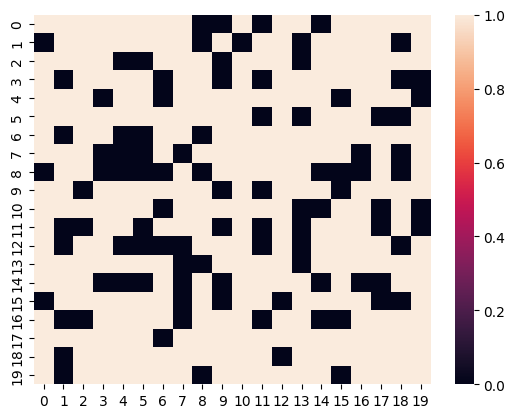

In [28]:
map_shape = (20, 20)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (5, 5),
    'max_episode_steps': 80,
}
heatmap(water_map)

ww = WaterWorld(config=config)
ww.reset()
print(ww.ship.geo, ww.way_point)

In [29]:
def alg_eval(env: WaterWorld, algo):
    all_actions = []
    total_profit = 0
    cords = []
    obs, _ = env.reset()
    while True:
        x = algo.compute_single_action(obs, explore=False)
        obs, profit, term, trunc, _ = env.step(x)

        all_actions.append(x)
        total_profit += profit
        cords.append(env.ship.int_geo)
        if term or trunc:
            break

    return {
        'total_profit': total_profit,
        'actions': all_actions,
        'cords': cords,
    }

-140.40760968509667


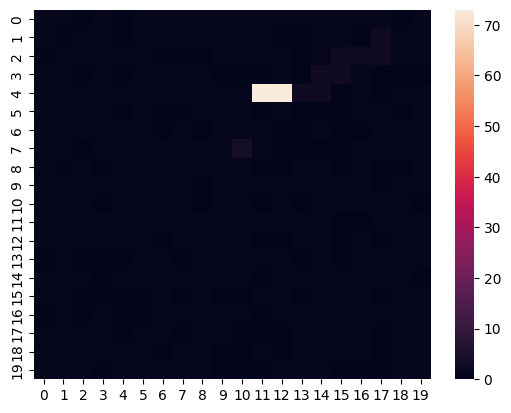

In [39]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

7.063103965061602


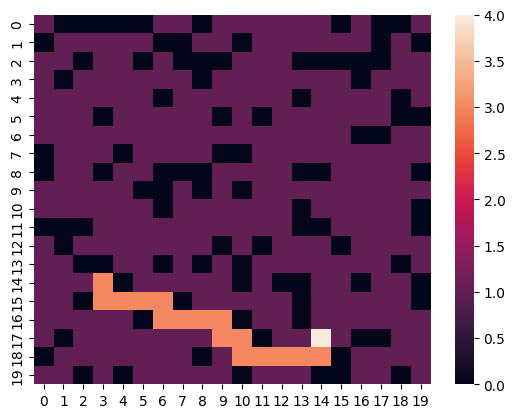

In [78]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

(42, 1) (30, 2)


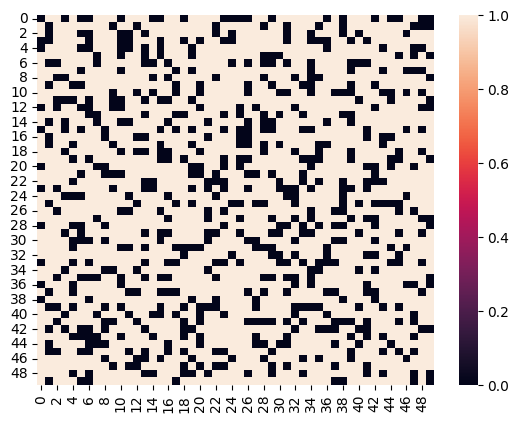

In [79]:
map_shape = (50, 50)
water_map = WaterWorld._generate_rnd_map(map_shape)

config = {
    'water_map': water_map,
    'map_shape': map_shape,
    'window_shape': (5, 5),
    'max_episode_steps': 100,
}
heatmap(water_map)

ww = WaterWorld(config=config)
ww.reset()
print(ww.ship.geo, ww.way_point)

3.6383798025958543


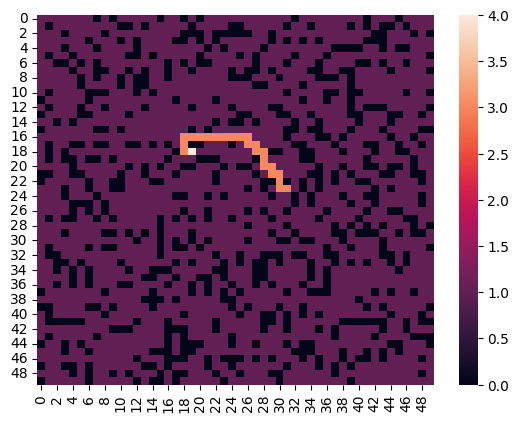

In [101]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

-144.49771739484024


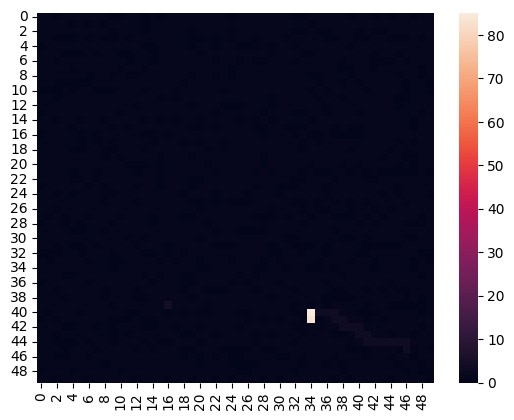

In [102]:
res = alg_eval(ww, algo)
water_map = ww.water_map.copy()
for cord in res['cords']:
    water_map[cord] += 2
water_map[ww.way_point] += 3
heatmap(water_map)
print(res['total_profit'])

In [86]:
import os
import dill
import numpy as np
from sklearn.neighbors import NearestNeighbors


def find_and_serialize_neighbors(grid: np.array, static_folder: str, file_name: str = "neighbors"):
    nbrs = NearestNeighbors(n_neighbors=32, algorithm='ball_tree').fit(grid)
    file_path = os.path.join(os.getcwd(), static_folder, file_name)
    with open(file_path, 'wb') as file:
        dill.dump(nbrs, file)

find_and_serialize_neighbors(grid=grid[["lat", "lon"]].values, static_folder="data")
serialized_neighbors = load_serialized_neighbors("data")

In [95]:
def get_slide_circle(geo_point: tuple[float, float], date: int):
    _, neighbors = serialized_neighbors.kneighbors([geo_point])
    return ice_integral_coefficient_on_step(neighbors, grid.values, date)

In [149]:
get_slide_circle((68.55, 73.7), 3)

array([[ 9.151162  , 11.807345  ,  9.151162  , 11.807345  ,  9.151162  ,
        11.807345  ,  9.151162  , 11.807345  ,  9.151162  , 11.807345  ,
        11.807345  , 11.807345  , 11.807345  , 11.807345  ,  9.151162  ,
        11.807345  ,  9.151162  , 11.807345  , 10.52504976,  9.151162  ,
        11.807345  ,  9.151162  ,  9.151162  , 10.52504976, 11.807345  ,
         9.151162  ,  9.151162  , 11.807345  ,  9.151162  , 10.52504976,
         9.151162  , 11.807345  ]])

In [ ]:
# Ограничения на скорость в зависимости от судна и льда
speed_limitations[detect_point_category(17)](ship)

In [127]:
ship_geo_x, ship_geo_y, waypoint_x, waypoint_y = routes.iloc[:, 3:].sample(n=1, replace=False)

In [1]:
import pandas as pd

from actors import (Ship, Geopoint, speed_limitations, detect_point_category, IceCategory,
                    VesselCategory, Port, Geopoint, VesselMoveStatus, Icebreaker, Route)
from utils import find_and_serialize_neighbors, load_serialized_neighbors
from route_metrics import ice_metrics_on_route, get_closest_grid_points_on_route_step, route_steps_on_edge, ice_integral_coefficient_on_step
grid = pd.read_excel(r"data\velocity.xlsx")
routes = pd.read_excel(r"data\routes.xlsx")
ports = pd.read_excel(r"data\ports.xlsx")
vessels = pd.read_excel(r"data\vessels.xlsx")
iceboats = pd.read_excel(r"data\iceboat.xlsx")
schedule = pd.read_excel(r"data\schedule.xlsx")

In [2]:
find_and_serialize_neighbors(grid=grid[["lat", "lon"]].values, static_folder="data")

config = {
    'max_episode_steps': 500,
    'neighbors_shape': (1, 32, ),
    'serialized_neighbors': load_serialized_neighbors("data"),
    'grid': grid,
    'routes': routes.iloc[:, 3:],
    'date_start': 2,
    'tick': 0.05
}

In [3]:
from envs.waterworld_one_map import WaterWorldGeo
wwg = WaterWorldGeo(config)
wwg.reset()

({'angle': array([0.], dtype=float32),
  'compas': array([-0.65217394, -0.3478261 ], dtype=float32),
  'slide_circle': array([[11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
          11.807345 , 12.1003065, 11.807345 , 12.1003065, 14.855172 ,
          14.855172 , 12.1003065, 14.855172 , 12.1003065, 12.1003065,
          14.855172 , 14.855172 , 12.1003065, 14.855172 , 14.855172 ,
          21.465307 , 14.855172 , 20.840322 , 20.840322 , 14.855172 ,
          14.855172 , 14.855172 , 21.348122 , 14.855172 , 21.348122 ,
          21.152815 , 14.855172 ]], dtype=float32),
  'velocity': array([12.], dtype=float32)},
 {})

In [4]:
wwg.step((1, 1))

({'angle': array([-0.09481906], dtype=float32),
  'compas': array([-0.6535088 , -0.34649122], dtype=float32),
  'slide_circle': array([[11.807345 , 11.807345 , 11.807345 , 11.807345 , 11.807345 ,
          12.1003065, 11.807345 , 11.807345 , 12.1003065, 14.855172 ,
          14.855172 , 12.1003065, 14.855172 , 12.1003065, 12.1003065,
          14.855172 , 14.855172 , 12.1003065, 14.855172 , 14.855172 ,
          21.465307 , 14.855172 , 20.840322 , 20.840322 , 14.855172 ,
          14.855172 , 14.855172 , 21.348122 , 14.855172 , 21.348122 ,
          21.152815 , 14.855172 ]], dtype=float32),
  'velocity': array([12.], dtype=float32)},
 -0.09481906497354586,
 False,
 False,
 {})

In [5]:
from ray.rllib.algorithms import PPOConfig
import warnings
warnings.filterwarnings("ignore")
try:
    algo.stop()
except:
    pass

training_options = {
    'train_batch_size': 128,
    #'sgd_minibatch': 64,
    #'lr': 1e-05,
    #'num_sgd_iter': 22,
    'model': {
        #'fcnet_activation': 'relu',
        #'fcnet_hiddens': [256, 256],
        'vf_share_layers': False,
        #'use_lstm': True,
    }
}

cql_config = (
    PPOConfig()
    .environment(env=WaterWorldGeo, env_config=config)
    .framework('torch')
    .rollouts(num_rollout_workers=0)
    .evaluation(evaluation_num_workers=0, evaluation_interval=1)
    .training(**training_options)
)
algo = cql_config.build()

d:\Code\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-13 19:44:10,174	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-13 19:44:13,128	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-13 19:44:14,685	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
2024-06-13 19:44:15,130	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-06-13 19:44:15,131	WARNING depreca

In [6]:
for i in range(20):
    hist = algo.step()
    print(f'Iter = {i}\tMean reward = {hist["evaluation"]["sampler_results"]["episode_reward_mean"]}')

2024-06-13 19:44:16,365	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!
2024-06-13 19:44:19,427	INFO worker.py:1749 -- Started a local Ray instance.


KeyError: 'sampler_results'

In [7]:
hist

{'evaluation': {'sampler_results': {'episode_reward_max': -724.1359977831164,
   'episode_reward_min': -772.7865425021164,
   'episode_reward_mean': -753.8307679326688,
   'episode_len_mean': 500.0,
   'episode_media': {},
   'episodes_this_iter': 10,
   'episodes_timesteps_total': 5000,
   'policy_reward_min': {},
   'policy_reward_max': {},
   'policy_reward_mean': {},
   'custom_metrics': {},
   'hist_stats': {'episode_reward': [-772.7865425021164,
     -752.1846079375609,
     -761.4160861376159,
     -738.5735086808597,
     -724.1359977831164,
     -761.3027412156559,
     -762.8621162165282,
     -747.0747587994704,
     -761.430225362478,
     -756.5410946912857],
    'episode_lengths': [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]},
   'sampler_perf': {'mean_raw_obs_processing_ms': 0.39023238404992344,
    'mean_inference_ms': 2.814997532109789,
    'mean_action_processing_ms': 0.20997673481661092,
    'mean_env_wait_ms': 3.7850189914562256,
    'mean_env_render_ms': 0.0}

In [10]:
def alg_eval(env: WaterWorldGeo, algo):
    all_actions = []
    total_profit = 0
    cords = []
    obs, _ = env.reset()
    while True:
        x = algo.compute_single_action(obs, explore=False)
        obs, profit, term, trunc, _ = env.step(x)

        all_actions.append(x)
        total_profit += profit
        cords.append(env.ship.location_point)
        if term or trunc:
            break

    return {
        'total_profit': total_profit,
        'actions': all_actions,
        'cords': cords,
    }

In [13]:
res = alg_eval(wwg, algo)

In [15]:
wwg.ship.total_time

6.797172131050408

In [14]:
res

{'total_profit': -529.8168390657224,
 'actions': [array([-0.04070109, -0.01160312], dtype=float32),
  array([0.08038437, 0.1349572 ], dtype=float32),
  array([0.10499334, 0.16323411], dtype=float32),
  array([0.10439241, 0.16332078], dtype=float32),
  array([0.10459471, 0.16339159], dtype=float32),
  array([0.10324275, 0.1626817 ], dtype=float32),
  array([0.10369408, 0.1633395 ], dtype=float32),
  array([0.09628808, 0.15963721], dtype=float32),
  array([0.0902909 , 0.16283083], dtype=float32),
  array([0.09222555, 0.1590004 ], dtype=float32),
  array([0.09364557, 0.16098404], dtype=float32),
  array([0.09740961, 0.16248345], dtype=float32),
  array([0.09834445, 0.16406798], dtype=float32),
  array([0.09344852, 0.15887487], dtype=float32),
  array([0.09074223, 0.15533113], dtype=float32),
  array([0.09180546, 0.15793455], dtype=float32),
  array([0.09261584, 0.15497589], dtype=float32),
  array([0.09190583, 0.15502143], dtype=float32),
  array([0.09043205, 0.15655696], dtype=float32),
